# 课程设计：深度学习模型ResNet实战：眼疾图像分类

本课程设计完成的内容：

- 完成基本的计算机视觉项目全流程。
- 眼疾数据集：数据集获取、分析及数据预处理方法。
- ResNet网络：应用眼疾数据集进行模型训练和测试。

## * 课程设计要求：
1. 作为附件提交程序设计报告（word文档），本平台提交（考试中的附件）；
1. 提交源代码（ipynb），本平台提交；
1. 提交录屏视频（视频要求小于200M），提交平台为超星平台（作业）。



基本的计算机视觉任务研发全流程如 **图1** 所示：

<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/7b7d2042785a41d3982ba20a776c9fe4e708301b69d3406d8d2d140c78ed54ae" width = "700"></center>
<center><br>图1：基本的计算机视觉任务研发全流程</br></center>

其中，基本的计算机视觉任务研发全流程包含模型训练、模型预测和模型部署三大步骤。每个步骤又包含单独的流程：

- 数据准备：根据网络接收的数据格式，完成相应的预处理和跑批量数据读取器操作，保证模型正常读取；
- 模型构建：设计卷积网络结构；
- 特征提取：使用构建的模型提取数据的特征信息；
- 损失函数：通过损失函数衡量模型的预测值和真实值的不一致程度，通常损失函数越小，模型性能越好；
- 模型评估：在模型训练中或训练结束后岁模型进行评估测试，观察准确率；
- 模型预测：使用训练好的模型进行测试，也需要准备数据和模型特征提取，最后对结果进行解析。

## 1 数据处理

### 1.1 数据集介绍

如今近视已经成为困扰人们健康的一项全球性负担，在近视人群中，有超过35%的人患有重度近视。近视会拉长眼睛的光轴，也可能引起视网膜或者络网膜的病变。随着近视度数的不断加深，高度近视有可能引发病理性病变，这将会导致以下几种症状：视网膜或者络网膜发生退化、视盘区域萎缩、漆裂样纹损害、Fuchs斑等。因此，及早发现近视患者眼睛的病变并采取治疗，显得非常重要。

[iChallenge-PM](https://ai.baidu.com/broad/introduction)是百度大脑和中山大学中山眼科中心联合举办的iChallenge比赛中，提供的关于病理性近视（Pathologic Myopia，PM）的医疗类数据集，包含1200个受试者的眼底视网膜图片，训练、验证和测试数据集各**400**张。iChallenge-PM分为**2类**：病理性近视和非病理性近视(包含高度近视和正常眼睛)，数据集命名规则如下：

- 病理性近视（PM）：文件名以P开头

- 非病理性近视（non-PM）：

  * 高度近视（high myopia）：文件名以H开头
  
  * 正常眼睛（normal）：文件名以N开头

有监督图像分类任务的数据包含图片和对应的类别标签(如猫、狗等)，我们将病理性患者的图片作为正样本，标签为1； 非病理性患者的图片作为负样本，标签为0。iChallenge-PM数据集的示意如 **图2** 所示。

<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/802336503be646aaa11567e4b2884bffa1b259d18451423ab50fe71bcfd968eb" width = "800"></center>
<center><br>图2：iChallenge-PM数据集示例</br></center>


### 1.2 数据集下载

AIStudio项目包含了iChallenge-PM数据集，位于data目录下，包括如下三个文件：
- training.zip：训练中的图片和标签
- validation.zip：验证集的图片
- valid_gt.zip：验证集的标签

通过如下命令解压数据集(**执行一次即可**)，解压缩后存放在/home/aistudio/work/palm目录下：

------
**注意**：

valid_gt.zip文件解压缩之后，需要将“/home/aistudio/work/palm/PALM-Validation-GT/”目录下的“PM_Label_and_Fovea_Location.xlsx”文件转存成.csv格式，本节代码示例中已经提前转成文件labels.csv。

------

从数据集中选取两张图片，并将图片显示出来。代码如下所示：

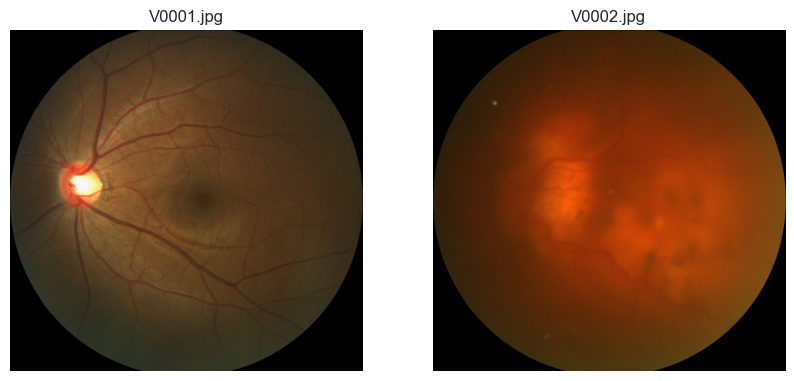

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import pandas as pd
# 文件名以N开头的是正常眼底图片，以P开头的是病变眼底图片
# 请显示两张图片（任意选择即可）
labels_df = pd.read_csv('C:\\Users\\33079\PycharmProjects\pys\\fin\labels.csv')
image_dir = 'C:\\Users\\33079\PycharmProjects\pys\\fin\PALM-Validation400'
# 获取图片文件名
image_files = labels_df['imgName'].tolist()
img1 = Image.open(os.path.join(image_dir, image_files[0]))
img2 = Image.open(os.path.join(image_dir, image_files[1]))
# 显示图片
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img1)
axs[0].set_title(image_files[0])
axs[0].axis('off')
axs[1].imshow(img2)
axs[1].set_title(image_files[1])
axs[1].axis('off')

plt.show()


In [2]:
# 获取图片形状
img1_shape = img1.size  # (width, height)
img2_shape = img2.size  # (width, height)

print('img1的形状是',img1_shape)
print('img2的形状是',img2_shape)

img1的形状是 (2124, 2056)
img2的形状是 (2124, 2056)


### 1.3 数据预处理

图像分类网络对输入图片的格式、大小有一定的要求，数据灌入模型前，需要对数据进行预处理操作，使图片满足网络训练以及预测的需要。本实验主要应用了如下方法：

- 调整图片大小：将每张图缩放到$224\times224$大小
- 归一化：将像素值调整到$[-1, 1]$之间

代码如下所示：

In [3]:
import cv2
import numpy as np
import paddle.vision.models as models
def transform_img(img):
    img = cv2.resize(img, (224, 224))
    img = np.transpose(img, (2,0,1))
    img = img.astype('float32')
    img = img / 255.
    img = img * 2.0 - 1.0
    return img

### 1.4 定义数据读取器

上面的代码仅展示了读取一张图片和预处理的方法，但在真实场景的模型训练与评估过程中，通常会使用批量数据读取和预处理的方式。

In [4]:
import cv2
import random
import numpy as np
import os
def data_loader(datadir, batch_size=10, mode = 'train'):
    filenames = os.listdir(datadir)
    def reader():
        if mode == 'train':
            random.shuffle(filenames)
        batch_imgs = []
        batch_labels = []
        for name in filenames:
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            if name[0] == 'H' or name[0] == 'N':
                label = 0
            elif name[0] == 'P':
                label = 1
            else:
                raise('Not excepted file name')
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).reshape(-1, 1)
            yield imgs_array, labels_array

    return reader()

# 定义验证集数据读取器
def valid_data_loader(datadir, csvfile, batch_size=10, mode='valid'):
    filelists = open(csvfile).readlines()
    def reader():
        batch_imgs = []
        batch_labels = []
        for line in filelists[1:]:
            line = line.strip().split(',')
            name = line[1]
            label = int(line[2])
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).reshape(-1, 1)
            yield imgs_array, labels_array

    return reader


In [5]:
import paddle
paddle.seed(100)
DATADIR = 'C:\\Users\\33079\PycharmProjects\pys\\fin\PALM-Training400'  # 替换成你自己的目录
train_loader = data_loader(DATADIR, batch_size=100, mode='train')
eval_loader = data_loader(DATADIR, batch_size=10, mode='eval')

## 2 模型构建

上一节定义好已经了解了ResNet模型结构，本节直接使用飞桨高层API中的Resnet50进行图像分类实验。

In [ ]:
import paddle
import paddle.nn as nn
import paddle.vision.transforms as T
from paddle.vision.datasets import DatasetFolder
from paddle.vision.models import resnet50
from paddle.metric import Accuracy
import numpy as np
import pandas as pd
from PIL import Image

# 读取 CSV 文件
labels_df = pd.read_csv('C:\\Users\\33079\PycharmProjects\pys\\fin\labels.csv')
model = paddle.Model(resnet50(pretrained=False, num_classes=2))  # 假设有2个分类
# Configure the model
model.prepare(
    optimizer=paddle.optimizer.Adam(parameters=model.parameters()),
    loss=nn.CrossEntropyLoss(),
    metrics=Accuracy()
)
model.fit(
    train_data=train_loader,
    eval_data=eval_loader,
    epochs=10,
    batch_size=32,
    save_dir='output',
    verbose=1
)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/10


D:\conda\envs\pytorch\lib\site-packages\paddle\nn\layer\norm.py:824: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


## 3 损失函数

模型训练过程中，需要使用损失函数来量化预测值和真实值之间的差异。
给定一个分类任务，$\mathbf y$表示样本$\mathbf x$的标签的真实概率分布，向量$\hat{\mathbf y}=p(\mathbf y|\mathbf x)$表示预测的标签概率分布。
训练目标是使得$\hat{\mathbf y}$尽可能地接近$\mathbf y$，通常可以使用**交叉熵损失函数**。
在给定$\mathbf y$的情况下，如果预测的概率分布$\hat{\mathbf y}$与标签真实的分布$\mathbf y$越接近，则交叉熵越小；如果$p(\mathbf x)$和$\mathbf y$越远，交叉熵就越大。

飞桨高层API中都为大家提供了实现好交叉熵损失函数，代码如下所示。

In [23]:
import paddle.nn.functional as F
loss_fn = F.cross_entropy

## 4 模型训练

使用交叉熵损失函数，并用SGD作为优化器来训练ResNet网络。 

In [24]:
import os
import random
import paddle
import numpy as np

class Runner(object):
    def __init__(self, model, optimizer, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.best_acc = 0
    
    def train_pm(self, train_datadir, val_datadir, **kwargs):
        print('start training ... ')
        self.model.train()
        
        num_epochs = kwargs.get('num_epochs', 0)
        csv_file = kwargs.get('csv_file', 0)
        save_path = kwargs.get("save_path", "C:\\Users\\33079\PycharmProjects\pys\\fin\output")

        train_loader = data_loader(train_datadir, batch_size=10, mode='train')
        
        for epoch in range(num_epochs):
            for batch_id, data in enumerate(train_loader()):
                x_data, y_data = data
                img = paddle.to_tensor(x_data)
                label = paddle.to_tensor(y_data)
                # 运行模型前向计算，得到预测值
                logits = model(img) 
                avg_loss = self.loss_fn(logits, label)
                
                if batch_id % 20 == 0:
                    print("epoch: {}, batch_id: {}, loss is: {:.4f}".format(epoch, batch_id, float(avg_loss.numpy())))
                # 反向传播，更新权重，清除梯度
                avg_loss.backward()
                self.optimizer.step()
                self.optimizer.clear_grad()
            
            acc = self.evaluate_pm(val_datadir, csv_file)
            self.model.train()
            if acc > self.best_acc:
                self.save_model(save_path)
                self.best_acc = acc

    # 模型评估阶段，使用'paddle.no_grad()'控制不计算和存储梯度
    @paddle.no_grad()
    def evaluate_pm(self, val_datadir, csv_file):
        self.model.eval()
        accuracies = []
        losses = []
        # 验证数据读取器
        valid_loader = valid_data_loader(val_datadir, csv_file)

        for batch_id, data in enumerate(valid_loader()):
            x_data, y_data = data
            img = paddle.to_tensor(x_data)
            label = paddle.to_tensor(y_data)
            # 运行模型前向计算，得到预测值
            logits = self.model(img)
            pred = F.softmax(logits)
            loss = self.loss_fn(pred, label)
            acc = paddle.metric.accuracy(pred, label)
            accuracies.append(acc.numpy())
            losses.append(loss.numpy())
        print("[validation] accuracy/loss: {:.4f}/{:.4f}".format(np.mean(accuracies), np.mean(losses)))
        return np.mean(accuracies)    
    
    # 模型评估阶段，使用'paddle.no_grad()'控制不计算和存储梯度
    @paddle.no_grad()
    def predict_pm(self, x, **kwargs):
        # 将模型设置为评估模式
        self.model.eval()
        # 运行模型前向计算，得到预测值
        logits = self.model(x)
        return logits
    
    def save_model(self, save_path):
        paddle.save(self.model.state_dict(), save_path + 'palm.pdparams')
        paddle.save(self.optimizer.state_dict(), save_path + 'palm.pdopt')
    
    def load_model(self, model_path):
        model_state_dict = paddle.load(model_path)
        self.model.set_state_dict(model_state_dict)

实例化Runner类，并传入训练配置，代码实现如下：

In [ ]:
# 开启0号GPU训练
use_gpu = True
paddle.device.set_device('gpu:0') if use_gpu else paddle.device.set_device('cpu')

# 定义优化器
opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())

runner = Runner(model, opt, loss_fn)

用Runner在训练集上训练多个个epoch **（自行设置）**，并保存准确率最高的模型作为最佳模型。

In [ ]:
import os
# 数据集路径(全部切换成自己的路径)
DATADIR = 'C:\\Users\\33079\PycharmProjects\pys\\fin\PALM-Training400'
DATADIR2 = 'C:\\Users\\33079\PycharmProjects\pys\\fin\PALM-Training400'
CSVFILE = 'C:\\Users\\33079\PycharmProjects\pys\\fin\labels.csv'  # 从超星平台上下载label.csv数据文件
# 设置迭代轮数（自行设置）
EPOCH_NUM = 5
PATH='C:\\Users\\33079\PycharmProjects\pys\\fin\output'
if not os.path.exists(PATH):
    os.makedirs(PATH)
runner.train_pm(DATADIR, DATADIR2, 
                num_epochs=EPOCH_NUM, csv_file=CSVFILE, save_path=PATH)

```
通过运行结果可以发现，使用ResNet在眼疾筛查数据集iChallenge-PM上，经过5个epoch的训练，在验证集上的准确率可以达到96%左右。
```

## 5 模型评估

使用测试数据对在训练过程中保存的最佳模型进行评价，观察模型在评估集上的准确率。代码实现如下：

In [ ]:
runner.load_model('C:\\Users\\33079\PycharmProjects\pys\\fin\output\\final.pdparams')
score = runner.evaluate_pm(DATADIR2, CSVFILE)

## 6 模型预测

同样地，也可以使用保存好的模型，对测试集中的某一个数据进行模型预测，观察模型效果。代码实现如下：

In [ ]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import paddle
import paddle.nn.functional as F
%matplotlib inline

# 加载最优模型
runner.load_model('C:\\Users\\33079\PycharmProjects\pys\\fin\output\\final.pdparams')

# 获取测试集中第一条数据
DATADIRv2 = 'C:\\Users\\33079\PycharmProjects\pys\\fin\PALM-Training400'
filelists = open('C:\\Users\\33079\PycharmProjects\pys\\fin\labels.csv').readlines()

line = filelists[1].strip().split(',')
name, label = line[1], int(line[2])

# 读取测试图片
img = cv2.imread(os.path.join(DATADIRv2, name))
# 测试图片预处理
trans_img = transform_img(img)
unsqueeze_img = paddle.unsqueeze(paddle.to_tensor(trans_img), axis=0)

# 模型预测
logits = runner.predict_pm(unsqueeze_img)
result=F.softmax(logits)
pred_class = paddle.argmax(result).numpy()

print("The true category is {} and the predicted category is {}".format(label, pred_class))

# 图片可视化
show_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(img)
plt.show()

## 本项目具体要求说明

* 基本要求：
1. 通过调用飞桨高层API Resnet50模型，实现眼疾识别。
1. 选择并使用一种优化器。
1. 实现随机选取一张图片进行预测。
1. 对已有的代码进行注释。
* 提高要求：
1. [更换其他模型](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/vision/Overview_cn.html#about-models)，看是否能得到更高的精度。
1. 使用多种优化器进行对比；
1. 随机选取9张图片，以9宫格的形式将预测结果显示出来。

## 小结
（必须填写）
> 请在此部分说明你完成的内容，具体对应的要求中的哪些。